In [1]:
import os
import re
import opensmile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from opensmile import FeatureSet, FeatureLevel
from contextlib import redirect_stdout

import tensorflow as tf

from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters as hp

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Input, LSTM

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
path = 'output/'
output_folder = os.listdir(path)
use_deprecated = False

In [3]:
dict_df_featuresets = {}
pattern = r'(Deprecated)'

for file in output_folder:
    csv_path = path+'/'+file
    temp_df = pd.read_csv(csv_path)
    temp_df = temp_df.drop(axis=1, columns = ['file', 'start', 'end'])
    if use_deprecated:    
        dict_df_featuresets[file[:-4]] = temp_df
    else:
        if re.findall(pattern, csv_path):
            pass
        else:
            dict_df_featuresets[file[:-4]] = temp_df

In [4]:
for featuresets in dict_df_featuresets:
    print(featuresets)
    
history_collection = {}

ComParE_2016
eGeMAPSv01a
eGeMAPSv02
emobase
GeMAPSv01a
GeMAPSv01b


In [5]:
def sm_model(num_of_features):
    
    model = Sequential()
    model.add(LSTM(128, return_sequences = True, input_shape=(num_of_features,1)))
    model.add(LSTM(128, return_sequences = True))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(9, activation = 'softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model

In [6]:
features_df = (dict_df_featuresets['emobase'])
print(features_df.shape)

(1975, 989)


In [7]:
X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [8]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_emobase = sm_model(number_of_features)
history_emobase = model_emobase.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_emobase.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

train_acc = history_emobase.history['acc']
train_loss = history_emobase.history['loss']
test_acc = history_emobase.history['val_acc']
test_loss = history_emobase.history['val_loss']
history_collection['emobase'] = history_emobase

Epoch 1/100


W1113 12:44:41.511554  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000022264435310> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 12:44:54.553053  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000022210A334C0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 15s - loss: 2.1432 - acc: 0.1708 - val_loss: 2.1566 - val_acc: 0.1422 - 15s/epoch - 174ms/step
Epoch 2/100
87/87 - 10s - loss: 2.1069 - acc: 0.1939 - val_loss: 2.1405 - val_acc: 0.1663 - 10s/epoch - 119ms/step
Epoch 3/100
87/87 - 10s - loss: 2.0918 - acc: 0.1881 - val_loss: 2.1259 - val_acc: 0.1759 - 10s/epoch - 120ms/step
Epoch 4/100
87/87 - 10s - loss: 2.0622 - acc: 0.1910 - val_loss: 2.0999 - val_acc: 0.2000 - 10s/epoch - 120ms/step
Epoch 5/100
87/87 - 10s - loss: 2.0173 - acc: 0.2185 - val_loss: 2.1397 - val_acc: 0.1928 - 10s/epoch - 119ms/step
Epoch 6/100
87/87 - 10s - loss: 2.0052 - acc: 0.2265 - val_loss: 2.0640 - val_acc: 0.1783 - 10s/epoch - 117ms/step
Epoch 7/100
87/87 -

Epoch 68/100
87/87 - 10s - loss: 0.1642 - acc: 0.9559 - val_loss: 3.8646 - val_acc: 0.2313 - 10s/epoch - 119ms/step
Epoch 69/100
87/87 - 10s - loss: 0.2201 - acc: 0.9378 - val_loss: 3.7043 - val_acc: 0.2217 - 10s/epoch - 119ms/step
Epoch 70/100
87/87 - 10s - loss: 0.1303 - acc: 0.9674 - val_loss: 3.6818 - val_acc: 0.2410 - 10s/epoch - 118ms/step
Epoch 71/100
87/87 - 10s - loss: 0.4196 - acc: 0.8683 - val_loss: 3.6280 - val_acc: 0.2313 - 10s/epoch - 119ms/step
Epoch 72/100
87/87 - 10s - loss: 0.7110 - acc: 0.7713 - val_loss: 3.3548 - val_acc: 0.2410 - 10s/epoch - 121ms/step
Epoch 73/100
87/87 - 10s - loss: 0.3293 - acc: 0.8922 - val_loss: 3.6813 - val_acc: 0.2217 - 10s/epoch - 119ms/step
Epoch 74/100
87/87 - 10s - loss: 0.2747 - acc: 0.9175 - val_loss: 3.6701 - val_acc: 0.2145 - 10s/epoch - 118ms/step
Epoch 75/100
87/87 - 10s - loss: 0.1653 - acc: 0.9559 - val_loss: 3.8461 - val_acc: 0.2289 - 10s/epoch - 119ms/step
Epoch 76/100
87/87 - 10s - loss: 0.5776 - acc: 0.8082 - val_loss: 3.5805

In [9]:
features_df = (dict_df_featuresets['ComParE_2016'])
X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [10]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_ComParE_2016 = sm_model(number_of_features)
history_ComParE_2016 = model_ComParE_2016.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_ComParE_2016.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

train_acc = history_ComParE_2016.history['acc']
train_loss = history_ComParE_2016.history['loss']
test_acc = history_ComParE_2016.history['val_acc']
test_loss = history_ComParE_2016.history['val_loss']
history_collection['ComParE_2016'] = history_ComParE_2016

Epoch 1/100


W1113 13:02:02.589302  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x000002226448CD30> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 13:02:51.305317  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000022264F08A60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 55s - loss: 2.0570 - acc: 0.2012 - val_loss: 2.0120 - val_acc: 0.2313 - 55s/epoch - 637ms/step
Epoch 2/100
87/87 - 52s - loss: 2.0252 - acc: 0.2149 - val_loss: 2.0233 - val_acc: 0.1759 - 52s/epoch - 602ms/step
Epoch 3/100
87/87 - 52s - loss: 2.0187 - acc: 0.2113 - val_loss: 2.0181 - val_acc: 0.1952 - 52s/epoch - 602ms/step
Epoch 4/100
87/87 - 52s - loss: 2.0046 - acc: 0.2243 - val_loss: 2.0045 - val_acc: 0.2000 - 52s/epoch - 602ms/step
Epoch 5/100
87/87 - 52s - loss: 2.0018 - acc: 0.2243 - val_loss: 2.0148 - val_acc: 0.2313 - 52s/epoch - 602ms/step
Epoch 6/100
87/87 - 52s - loss: 1.9887 - acc: 0.2395 - val_loss: 1.9840 - val_acc: 0.2072 - 52s/epoch - 603ms/step
Epoch 7/100
87/87 -

Epoch 68/100
87/87 - 120s - loss: 0.4248 - acc: 0.8647 - val_loss: 3.1993 - val_acc: 0.2361 - 120s/epoch - 1s/step
Epoch 69/100
87/87 - 126s - loss: 0.2607 - acc: 0.9298 - val_loss: 3.2094 - val_acc: 0.2482 - 126s/epoch - 1s/step
Epoch 70/100
87/87 - 122s - loss: 0.1476 - acc: 0.9732 - val_loss: 3.2894 - val_acc: 0.2458 - 122s/epoch - 1s/step
Epoch 71/100
87/87 - 123s - loss: 0.0942 - acc: 0.9906 - val_loss: 3.3633 - val_acc: 0.2337 - 123s/epoch - 1s/step
Epoch 72/100
87/87 - 86s - loss: 0.1336 - acc: 0.9768 - val_loss: 3.5344 - val_acc: 0.2386 - 86s/epoch - 988ms/step
Epoch 73/100
87/87 - 83s - loss: 0.1914 - acc: 0.9486 - val_loss: 3.5069 - val_acc: 0.2193 - 83s/epoch - 950ms/step
Epoch 74/100
87/87 - 83s - loss: 0.1108 - acc: 0.9819 - val_loss: 3.5314 - val_acc: 0.2578 - 83s/epoch - 957ms/step
Epoch 75/100
87/87 - 84s - loss: 0.0758 - acc: 0.9899 - val_loss: 3.5768 - val_acc: 0.2361 - 84s/epoch - 966ms/step
Epoch 76/100
87/87 - 82s - loss: 0.0546 - acc: 0.9964 - val_loss: 3.6588 - v

In [11]:
history_collection['ComParE_2016'] = history_ComParE_2016

In [12]:
features_df = (dict_df_featuresets['eGeMAPSv01a'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [13]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_eGeMAPSv01a = sm_model(number_of_features)
history_eGeMAPSv01a = model_eGeMAPSv01a.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_eGeMAPSv01a.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

train_acc = history_eGeMAPSv01a.history['acc']
train_loss = history_eGeMAPSv01a.history['loss']
test_acc = history_eGeMAPSv01a.history['val_acc']
test_loss = history_eGeMAPSv01a.history['val_loss']
history_collection['eGeMAPSv01a'] = history_eGeMAPSv01a

Epoch 1/100


W1113 14:50:53.741295  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000022266BA2D30> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 14:50:57.884994  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000222647278B0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 5s - loss: 2.0495 - acc: 0.2127 - val_loss: 1.9597 - val_acc: 0.2193 - 5s/epoch - 58ms/step
Epoch 2/100
87/87 - 1s - loss: 1.8630 - acc: 0.2692 - val_loss: 1.8685 - val_acc: 0.2892 - 1s/epoch - 16ms/step
Epoch 3/100
87/87 - 1s - loss: 1.7834 - acc: 0.3249 - val_loss: 1.7967 - val_acc: 0.3205 - 1s/epoch - 16ms/step
Epoch 4/100
87/87 - 1s - loss: 1.7335 - acc: 0.3329 - val_loss: 1.7202 - val_acc: 0.3325 - 1s/epoch - 16ms/step
Epoch 5/100
87/87 - 1s - loss: 1.6594 - acc: 0.3690 - val_loss: 1.6854 - val_acc: 0.3687 - 1s/epoch - 16ms/step
Epoch 6/100
87/87 - 1s - loss: 1.6513 - acc: 0.3705 - val_loss: 1.6703 - val_acc: 0.3711 - 1s/epoch - 16ms/step
Epoch 7/100
87/87 - 1s - loss: 1.5992

Epoch 70/100
87/87 - 1s - loss: 0.0411 - acc: 0.9971 - val_loss: 2.5650 - val_acc: 0.4145 - 1s/epoch - 16ms/step
Epoch 71/100
87/87 - 1s - loss: 0.0404 - acc: 0.9957 - val_loss: 2.5933 - val_acc: 0.4241 - 1s/epoch - 16ms/step
Epoch 72/100
87/87 - 1s - loss: 0.0276 - acc: 0.9986 - val_loss: 2.6518 - val_acc: 0.4337 - 1s/epoch - 16ms/step
Epoch 73/100
87/87 - 1s - loss: 0.0182 - acc: 1.0000 - val_loss: 2.6773 - val_acc: 0.4265 - 1s/epoch - 17ms/step
Epoch 74/100
87/87 - 1s - loss: 0.0158 - acc: 1.0000 - val_loss: 2.7007 - val_acc: 0.4313 - 1s/epoch - 16ms/step
Epoch 75/100
87/87 - 1s - loss: 0.0133 - acc: 1.0000 - val_loss: 2.7680 - val_acc: 0.4313 - 1s/epoch - 16ms/step
Epoch 76/100
87/87 - 1s - loss: 0.0131 - acc: 0.9993 - val_loss: 2.8013 - val_acc: 0.4434 - 1s/epoch - 16ms/step
Epoch 77/100
87/87 - 1s - loss: 0.0124 - acc: 0.9986 - val_loss: 2.8273 - val_acc: 0.4410 - 1s/epoch - 16ms/step
Epoch 78/100
87/87 - 1s - loss: 0.0112 - acc: 1.0000 - val_loss: 2.8710 - val_acc: 0.4458 - 1s/e

In [14]:
features_df = (dict_df_featuresets['eGeMAPSv02'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [15]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_eGeMAPSv02 = sm_model(number_of_features)
history_eGeMAPSv02 = model_eGeMAPSv02.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_eGeMAPSv02.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

train_acc = history_eGeMAPSv02.history['acc']
train_loss = history_eGeMAPSv02.history['loss']
test_acc = history_eGeMAPSv02.history['val_acc']
test_loss = history_eGeMAPSv02.history['val_loss']
history_collection['eGeMAPSv02'] = history_eGeMAPSv02

Epoch 1/100


W1113 14:53:18.742255  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000022266A66940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 14:53:22.649572  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000022270FBEAF0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 5s - loss: 2.0197 - acc: 0.2164 - val_loss: 1.9403 - val_acc: 0.2048 - 5s/epoch - 54ms/step
Epoch 2/100
87/87 - 1s - loss: 1.8899 - acc: 0.2685 - val_loss: 1.8747 - val_acc: 0.2530 - 1s/epoch - 16ms/step
Epoch 3/100
87/87 - 1s - loss: 1.7987 - acc: 0.3198 - val_loss: 1.7678 - val_acc: 0.3349 - 1s/epoch - 16ms/step
Epoch 4/100
87/87 - 1s - loss: 1.7090 - acc: 0.3538 - val_loss: 1.7963 - val_acc: 0.3036 - 1s/epoch - 16ms/step
Epoch 5/100
87/87 - 1s - loss: 1.6544 - acc: 0.3661 - val_loss: 1.7200 - val_acc: 0.3542 - 1s/epoch - 16ms/step
Epoch 6/100
87/87 - 1s - loss: 1.6279 - acc: 0.3806 - val_loss: 1.6795 - val_acc: 0.3398 - 1s/epoch - 16ms/step
Epoch 7/100
87/87 - 1s - loss: 1.5703

Epoch 70/100
87/87 - 1s - loss: 0.0162 - acc: 0.9993 - val_loss: 2.7975 - val_acc: 0.4313 - 1s/epoch - 16ms/step
Epoch 71/100
87/87 - 1s - loss: 0.0128 - acc: 1.0000 - val_loss: 2.8410 - val_acc: 0.4289 - 1s/epoch - 16ms/step
Epoch 72/100
87/87 - 1s - loss: 0.0116 - acc: 1.0000 - val_loss: 2.8755 - val_acc: 0.4169 - 1s/epoch - 16ms/step
Epoch 73/100
87/87 - 1s - loss: 0.0102 - acc: 1.0000 - val_loss: 2.9187 - val_acc: 0.4217 - 1s/epoch - 16ms/step
Epoch 74/100
87/87 - 1s - loss: 0.0091 - acc: 1.0000 - val_loss: 2.9494 - val_acc: 0.4193 - 1s/epoch - 16ms/step
Epoch 75/100
87/87 - 1s - loss: 0.0091 - acc: 1.0000 - val_loss: 2.9556 - val_acc: 0.4265 - 1s/epoch - 16ms/step
Epoch 76/100
87/87 - 1s - loss: 0.0077 - acc: 1.0000 - val_loss: 2.9763 - val_acc: 0.4217 - 1s/epoch - 16ms/step
Epoch 77/100
87/87 - 1s - loss: 0.0071 - acc: 1.0000 - val_loss: 2.9870 - val_acc: 0.4265 - 1s/epoch - 16ms/step
Epoch 78/100
87/87 - 1s - loss: 0.0068 - acc: 1.0000 - val_loss: 3.0008 - val_acc: 0.4241 - 1s/e

In [16]:
features_df = (dict_df_featuresets['GeMAPSv01a'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [17]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_GeMAPSv01a = sm_model(number_of_features)
history_GeMAPSv01a = model_GeMAPSv01a.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_GeMAPSv01a.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

train_acc = history_GeMAPSv01a.history['acc']
train_loss = history_GeMAPSv01a.history['loss']
test_acc = history_GeMAPSv01a.history['val_acc']
test_loss = history_GeMAPSv01a.history['val_loss']
history_collection['GeMAPSv01a'] = history_GeMAPSv01a

Epoch 1/100


W1113 14:55:42.413159  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x0000022267193700> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 14:55:45.981693  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002227DA87A60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 4s - loss: 2.0118 - acc: 0.2156 - val_loss: 1.8744 - val_acc: 0.2337 - 4s/epoch - 50ms/step
Epoch 2/100
87/87 - 1s - loss: 1.8687 - acc: 0.2764 - val_loss: 1.7707 - val_acc: 0.3060 - 1s/epoch - 13ms/step
Epoch 3/100
87/87 - 1s - loss: 1.8100 - acc: 0.2923 - val_loss: 1.8622 - val_acc: 0.2699 - 1s/epoch - 13ms/step
Epoch 4/100
87/87 - 1s - loss: 1.7852 - acc: 0.3133 - val_loss: 1.7886 - val_acc: 0.3229 - 1s/epoch - 13ms/step
Epoch 5/100
87/87 - 1s - loss: 1.7353 - acc: 0.3256 - val_loss: 1.7265 - val_acc: 0.3205 - 1s/epoch - 13ms/step
Epoch 6/100
87/87 - 1s - loss: 1.6831 - acc: 0.3531 - val_loss: 1.7648 - val_acc: 0.3181 - 1s/epoch - 13ms/step
Epoch 7/100
87/87 - 1s - loss: 1.6342

Epoch 70/100
87/87 - 1s - loss: 0.4790 - acc: 0.8329 - val_loss: 2.4586 - val_acc: 0.4217 - 1s/epoch - 13ms/step
Epoch 71/100
87/87 - 1s - loss: 0.3793 - acc: 0.8683 - val_loss: 2.1870 - val_acc: 0.4482 - 1s/epoch - 13ms/step
Epoch 72/100
87/87 - 1s - loss: 0.2070 - acc: 0.9305 - val_loss: 2.2289 - val_acc: 0.4578 - 1s/epoch - 13ms/step
Epoch 73/100
87/87 - 1s - loss: 0.1570 - acc: 0.9544 - val_loss: 2.3011 - val_acc: 0.4771 - 1s/epoch - 12ms/step
Epoch 74/100
87/87 - 1s - loss: 0.1058 - acc: 0.9776 - val_loss: 2.3342 - val_acc: 0.4699 - 1s/epoch - 13ms/step
Epoch 75/100
87/87 - 1s - loss: 0.0934 - acc: 0.9776 - val_loss: 2.6319 - val_acc: 0.4337 - 1s/epoch - 13ms/step
Epoch 76/100
87/87 - 1s - loss: 0.3640 - acc: 0.8763 - val_loss: 2.4429 - val_acc: 0.4337 - 1s/epoch - 12ms/step
Epoch 77/100
87/87 - 1s - loss: 0.2333 - acc: 0.9255 - val_loss: 2.4415 - val_acc: 0.4506 - 1s/epoch - 13ms/step
Epoch 78/100
87/87 - 1s - loss: 0.1676 - acc: 0.9515 - val_loss: 2.5761 - val_acc: 0.4602 - 1s/e

In [18]:
features_df = (dict_df_featuresets['GeMAPSv01b'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [19]:
epoch = 100
batch_size = 16

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

callback_list = [log_csv]

number_of_features = features_df.shape[1] - 1
model_GeMAPSv01b = sm_model(number_of_features)
history_GeMAPSv01b = model_GeMAPSv01b.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_GeMAPSv01b.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

train_acc = history_GeMAPSv01b.history['acc']
train_loss = history_GeMAPSv01b.history['loss']
test_acc = history_GeMAPSv01b.history['val_acc']
test_loss = history_GeMAPSv01b.history['val_loss']
history_collection['GeMAPSv01a'] = history_GeMAPSv01b

Epoch 1/100


W1113 14:57:36.931930  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x000002227E2A9AF0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W1113 14:57:40.619814  8652 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000222E01FF3A0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
87/87 - 4s - loss: 2.0099 - acc: 0.2127 - val_loss: 1.8876 - val_acc: 0.2651 - 4s/epoch - 51ms/step
Epoch 2/100
87/87 - 1s - loss: 1.8917 - acc: 0.2822 - val_loss: 1.8601 - val_acc: 0.2530 - 1s/epoch - 13ms/step
Epoch 3/100
87/87 - 1s - loss: 1.8030 - acc: 0.3003 - val_loss: 1.7531 - val_acc: 0.3277 - 1s/epoch - 13ms/step
Epoch 4/100
87/87 - 1s - loss: 1.7710 - acc: 0.3336 - val_loss: 1.7745 - val_acc: 0.3181 - 1s/epoch - 13ms/step
Epoch 5/100
87/87 - 1s - loss: 1.7087 - acc: 0.3415 - val_loss: 1.7464 - val_acc: 0.2843 - 1s/epoch - 12ms/step
Epoch 6/100
87/87 - 1s - loss: 1.6580 - acc: 0.3755 - val_loss: 1.6661 - val_acc: 0.3566 - 1s/epoch - 12ms/step
Epoch 7/100
87/87 - 1s - loss: 1.6167

Epoch 70/100
87/87 - 1s - loss: 0.0105 - acc: 1.0000 - val_loss: 2.9002 - val_acc: 0.4699 - 1s/epoch - 13ms/step
Epoch 71/100
87/87 - 1s - loss: 0.0084 - acc: 1.0000 - val_loss: 2.9230 - val_acc: 0.4651 - 1s/epoch - 13ms/step
Epoch 72/100
87/87 - 1s - loss: 0.0081 - acc: 1.0000 - val_loss: 2.9225 - val_acc: 0.4699 - 1s/epoch - 13ms/step
Epoch 73/100
87/87 - 1s - loss: 0.0080 - acc: 1.0000 - val_loss: 2.9837 - val_acc: 0.4651 - 1s/epoch - 13ms/step
Epoch 74/100
87/87 - 1s - loss: 0.0070 - acc: 1.0000 - val_loss: 2.9687 - val_acc: 0.4771 - 1s/epoch - 13ms/step
Epoch 75/100
87/87 - 1s - loss: 0.0059 - acc: 1.0000 - val_loss: 3.0041 - val_acc: 0.4699 - 1s/epoch - 13ms/step
Epoch 76/100
87/87 - 1s - loss: 0.0050 - acc: 1.0000 - val_loss: 3.0459 - val_acc: 0.4651 - 1s/epoch - 13ms/step
Epoch 77/100
87/87 - 1s - loss: 0.0052 - acc: 1.0000 - val_loss: 3.0561 - val_acc: 0.4699 - 1s/epoch - 13ms/step
Epoch 78/100
87/87 - 1s - loss: 0.0048 - acc: 1.0000 - val_loss: 3.0699 - val_acc: 0.4578 - 1s/e

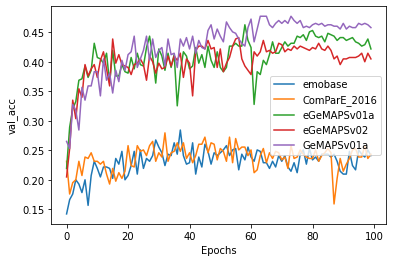

In [20]:
plot_data_testAcc = []
plot_data_testLoss = []
plot_data_trainAcc = []
plot_data_trainLoss = []
for history in history_collection:
    plt.plot(list(range(len(history_collection[history].history['val_acc']))), history_collection[history].history['val_acc'], label = history)
plt.xlabel('Epochs')
plt.ylabel('val_acc')
plt.legend()

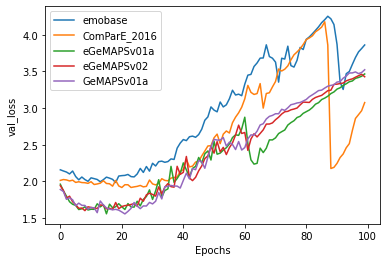

In [21]:
plot_data_testAcc = []
plot_data_testLoss = []
plot_data_trainAcc = []
plot_data_trainLoss = []
for history in history_collection:
    plt.plot(list(range(len(history_collection[history].history['val_acc']))), history_collection[history].history['val_loss'], label = history)
plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.legend()